# 03 - Vertex AI > Pipelines - AutoML automated pipeline

Use[ Kubeflow](https://www.kubeflow.org/) Pipelines running on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) to orchestrate the process of training a custom model with AutoML Tabular and deploy it to a Vertex AI Endpoint for serving (online and batch) predictions and explanations.  
### Prerequisites:
-  01 -  BigQuery - Table Data Source

### Resources:
-  [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/build-pipeline#google-cloud-components) see aiplatform.PipelineJob
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [Kubeflow Pipelines Components for Google Cloud](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud)

### Related Training:
-  Codelab: [Vertex AI Pipelines Introduction](https://codelabs.developers.google.com/vertex-mlmd-pipelines#0)


## Setup

inputs:

In [64]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'genai-demo-2024'

In [65]:
REGION = 'us-central1'
# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'ml_datasets'
BQ_TABLE = 'ulb_fraud_detection'
NOTEBOOK = '03'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id Feedback' # add more variables to the string with space delimiters

packages:

In [3]:
#!pip install -U google-cloud-pipeline-components -U -q

In [66]:
from google.cloud import aiplatform
from datetime import datetime
import kfp
from kfp import compiler
#import kfp.v2.dsl as dsl
#import google_cloud_pipeline_components as gcc_aip
from google_cloud_pipeline_components.v1.dataset import TabularDatasetCreateOp
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [67]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

parameters:

In [68]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{BQ_TABLE}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [69]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'292219499736-compute@developer.gserviceaccount.com'

List the service accounts current roles:

In [70]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/aiplatform.admin
roles/aiplatform.notebookRuntimeAdmin
roles/aiplatform.user
roles/artifactregistry.admin
roles/bigquery.admin
roles/cloudbuild.builds.editor
roles/cloudfunctions.admin
roles/cloudscheduler.admin
roles/dataproc.worker
roles/dialogflow.client
roles/dialogflow.reader
roles/iam.serviceAccountAdmin
roles/iam.serviceAccountUser
roles/logging.admin
roles/ml.admin
roles/notebooks.runner
roles/pubsub.admin
roles/resourcemanager.projectIamAdmin
roles/run.admin
roles/secretmanager.admin
roles/serviceusage.serviceUsageAdmin
roles/serviceusage.serviceUsageConsumer
roles/storage.admin
roles/storage.objectAdmin


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [71]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Pipeline (KFP) Definition
- Flow
    - Create Vertex AI Dataset from link to BigQuery table
    - Create Vertex AI AutoML Tabular Training Job
    - Create Endpoint and Depoy trained model
    
Use [AI Platform Pipeline Components](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/)
- Specifically, [AutoMLTabularTrainingJobRunOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.AutoMLTabularTrainingJobRunOp)

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

In [72]:
@kfp.dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-{BQ_TABLE}-{TIMESTAMP}',
    pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/'
)
def pipeline(
    project: str,
    dataname: str,
    display_name: str,
    deploy_machine: str,
    bq_source: str,
    var_target: str,
    var_omit: str,
    features: dict,
    labels: dict 
):
    
    # dataset
    dataset = TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source,
        labels = labels
    )
    
    # training
    model = AutoMLTabularTrainingJobRunOp(
        project = project,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = "maximize-au-prc",
        budget_milli_node_hours = 1000,
        disable_early_stopping=False,
        column_specs = features,
        dataset = dataset.outputs['dataset'],
        target_column = var_target,
        predefined_split_column_name = 'splits',
        labels = labels
    )
    
    # Endpoint: Creation
    endpoint = EndpointCreateOp(
        project = project,
        display_name = display_name,
        labels = labels
    )
    
    # Endpoint: Deployment of Model
    deployment = ModelDeployOp(
        model = model.outputs["model"],
        endpoint = endpoint.outputs["endpoint"],
        dedicated_resources_min_replica_count = 1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type= deploy_machine
    )

---
## Compile Pipeline

In [73]:
compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

Move compiled pipeline files to GCS Bucket

In [74]:
!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/03/03.json [Content-Type=application/json]...
/ [1 files][ 46.6 KiB/ 46.6 KiB]                                                
Operation completed over 1 objects/46.6 KiB.                                     


---
## Create Vertex AI Pipeline Job

Get features dictionary for the pipeline input:

In [75]:
# get feature names
query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{BQ_TABLE}_prepped'"
schema = bq.query(query).to_dataframe()
OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
features = dict.fromkeys(features, 'auto')

query


"SELECT * FROM genai-demo-2024.ml_datasets.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'ulb_fraud_detection_prepped'"

Run The pipeline:

In [76]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    template_path = f"{URI}/{TIMESTAMP}/kfp/{NOTEBOOK}.json",
    parameter_values = {
        "project" : PROJECT_ID,
        "dataname" : BQ_TABLE,
        "display_name" : f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
        "deploy_machine" : DEPLOY_COMPUTE,
        "bq_source" : f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
        "var_target" : VAR_TARGET,
        "var_omit" : VAR_OMIT,
        "features" : features,
        "labels" : {'notebook': NOTEBOOK}       
    },
    labels = {'notebook': NOTEBOOK},
    enable_caching=False
)

In [ ]:
# 2h17min
response = pipeline.run(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240409142755-20240409144542
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240409142755-20240409144542')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-03-ulb-fraud-detection-20240409142755-20240409144542?project=292219499736
PipelineJob projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240409142755-20240409144542 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240409142755-20240409144542 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detecti

Visual Representation of the pipeline can be viewed in the colsole:

In [ ]:
print(f"Review the Pipeline as it runs here:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/pipelines/runs/{pipeline.resource_name.split('/')[-1]}?project={PROJECT_ID}")

Retrieve the pipeline information:

In [81]:
aiplatform.get_pipeline_df(pipeline = f'kfp-{NOTEBOOK}-{BQ_TABLE}-{TIMESTAMP}')

#aiplatform.get_pipeline_df(pipeline = 'kfp-03-ulb-fraud-detection-20240409142755')

,pipeline_name,run_name,param.input:bq_source,param.input:labels,param.input:features,param.input:var_target,param.input:dataname,param.vmlmd_lineage_integration,param.input:project,param.input:display_name,param.input:deploy_machine,param.input:var_omit
0,kfp-03-ulb-fraud-detection-20240409142755,kfp-03-ulb-fraud-detection-20240409142755-2024...,bq://genai-demo-2024.ml_datasets.ulb_fraud_det...,{'notebook': '03'},"{'V23': 'auto', 'V21': 'auto', 'Amount': 'auto...",Class,ulb_fraud_detection,{'pipeline_run_component': {'location_id': 'us...,genai-demo-2024,03_ulb_fraud_detection_20240409142755,n1-standard-4,transaction_id Feedback
1,kfp-03-ulb-fraud-detection-20240409142755,kfp-03-ulb-fraud-detection-20240409142755-2024...,bq://genai-demo-2024.ml_datasets.ulb_fraud_det...,{'notebook': '03'},{},Class,ulb_fraud_detection,{'pipeline_run_component': {'location_id': 'us...,genai-demo-2024,03_ulb_fraud_detection_20240409142755,n1-standard-4,transaction_id Feedback


---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

Get the Model:

In [82]:
models = aiplatform.Model.list(filter=f'labels.notebook={NOTEBOOK}')

In [83]:
model = models[0]
model.resource_name

'projects/292219499736/locations/us-central1/models/4143699784785461248'

Retrives the aggregate model evalution metrics for the model as a whole.  

Either:
- First, use `model.list_model_evaluations()` to retrieve the evaluation id, then use `model.get_model_evaluation(evaluation_id = )` for the evaluation id
- Or, use `.get_model_evaluation()` and it will retrieve the first model evaluation

In [84]:
evaluation = model.get_model_evaluation().to_dict() # get first evaluation

In [85]:
evaluation.keys()

dict_keys(['name', 'metricsSchemaUri', 'metrics', 'createTime', 'sliceDimensions', 'modelExplanation'])

In [86]:
evaluation['metrics'].keys()

dict_keys(['auPrc', 'auRoc', 'logLoss', 'confusionMatrix', 'confidenceMetrics'])

In [87]:
evaluation['metrics']['auPrc']

0.999763

In [88]:
evaluation['metrics']['confidenceMetrics'][3]

{'falseNegativeCount': '5',
 'recallAt1': 0.9997472,
 'falsePositiveRateAt1': 0.00025276234,
 'truePositiveCount': '27689',
 'recall': 0.99981946,
 'trueNegativeCount': '27624',
 'confidenceThreshold': 0.01,
 'falsePositiveRate': 0.0025276232,
 'precisionAt1': 0.9997472,
 'confusionMatrix': {'rows': [[27666.0, 1.0, 0.0],
   [6.0, 21.0, 0.0],
   [0.0, 0.0, 0.0]],
  'annotationSpecs': [{'displayName': '0', 'id': '0'},
   {'displayName': '1', 'id': '1'},
   {'displayName': 'DROPPED', 'id': 'DROPPED'}]},
 'precision': 0.9974783,
 'f1ScoreAt1': 0.9997472,
 'f1ScoreMacro': 0.7243001,
 'f1Score': 0.9986475,
 'falsePositiveCount': '70',
 'f1ScoreMicro': 0.9986475}

Review several of the metrics included in the evaluation.  Also, compare these to the results in the console view.

In [89]:
print(f"Review this model in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/evaluations/{evaluation['name'].split('/')[-1]}?project={PROJECT_ID}")

Review this model in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/4143699784785461248/versions/1/evaluations/4543694834158603879?project=genai-demo-2024


In [90]:
evaluation['metrics']['auPrc']

0.999763

In [91]:
for i in range(len(evaluation['metrics']['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', evaluation['metrics']['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', evaluation['metrics']['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [27666.0, 1.0, 0.0]
True Label =  1  has Predicted labels =  [6.0, 21.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model as well using the .gapic api version:

In [92]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [93]:
slices = model_client.list_model_evaluation_slices(parent = evaluation['name'])

In [94]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.9998186
Label =  1 has auPrc =  0.7938121


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [116]:
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, splits, transaction_id, Feedback)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped
        WHERE splits='TEST'
        LIMIT 10
    """
).to_dataframe()

In [117]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,135426.0,2.132591,-0.079070,-2.347959,0.060631,0.866875,-0.526201,0.438905,-0.192546,0.160300,...,-0.281757,0.085068,0.315750,-0.067077,0.133487,0.401384,0.704240,-0.132129,-0.098000,0.760000
1,97430.0,0.168853,0.136885,1.892742,-0.242915,-0.184315,-0.024114,0.012281,-0.310277,2.110540,...,-0.045857,-0.045172,0.519687,0.061692,0.041079,-1.382377,0.295097,-0.337653,-0.351998,14.950000
2,40864.0,0.491464,-0.946247,-0.345005,1.495592,-0.019860,0.454469,0.629021,-0.123851,0.138186,...,0.679091,0.085650,-0.320323,-0.513776,-0.709041,0.672462,-0.304324,-0.025661,0.075820,387.790009
3,30606.0,-0.462273,-0.355619,2.048961,-1.706096,-1.085680,-0.303081,-0.704979,-0.057419,-2.316110,...,-0.171561,-0.032267,0.285379,-0.358489,-0.109457,0.220757,0.050688,0.006466,0.062116,18.400000


In [118]:
import pandas as pd
pred['Time'] = pd.to_numeric(pred['Time'], errors='coerce')


# Now convert your DataFrame to a dictionary
newobs = pred.to_dict(orient='records')

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [ ]:
# Parse the dictionary to the format expected by the model for prediction
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]
#instances

### Get Predictions: Python Client

In [120]:
aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')

 resource name: projects/292219499736/locations/us-central1/endpoints/3365532524854902784]

In [121]:
# Proceed with getting the endpoint and making a prediction
endpoint = aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')[0]
endpoint.display_name

'03_ulb_fraud_detection_20240409142755'

In [122]:
prediction = endpoint.predict(instances = instances) # or instances = newobs
#prediction
prediction.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9998624324798584, 0.0001375129650114104]}

In [123]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [124]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newobs[0]]}))

In [125]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "classes": [
        "0",
        "1"
      ],
      "scores": [
        0.9998624324798584,
        0.00013751296501141039
      ]
    }
  ],
  "deployedModelId": "5042516455631880192",
  "model": "projects/292219499736/locations/us-central1/models/4143699784785461248",
  "modelDisplayName": "03_ulb_fraud_detection_20240409142755",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [126]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9998624324798584, 0.0001375129650114104]}]


## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [127]:
explanation = endpoint.explain(instances = instances)

In [128]:
explanation.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9998624324798584, 0.0001375129650114104]}

In [129]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.999984085559845
instance output 0.9998624324798584
output_index [0]
output display value 0
approximation error 0.006948239931506695


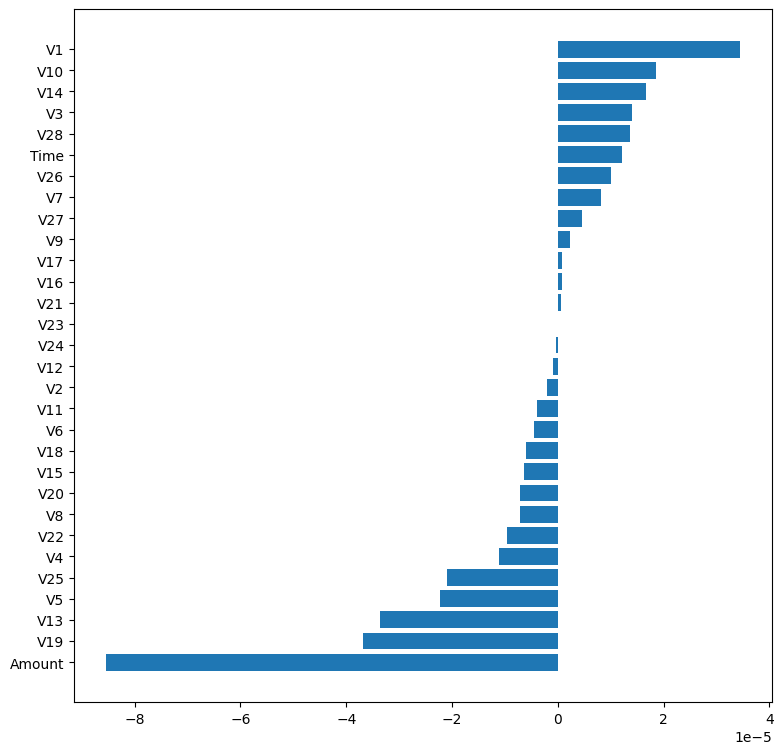

In [130]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation=True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/292219499736/locations/us-central1/batchPredictionJobs/1664064703510347776
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/292219499736/locations/us-central1/batchPredictionJobs/1664064703510347776')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/1664064703510347776?project=292219499736
